# Titanic生存率预测项目

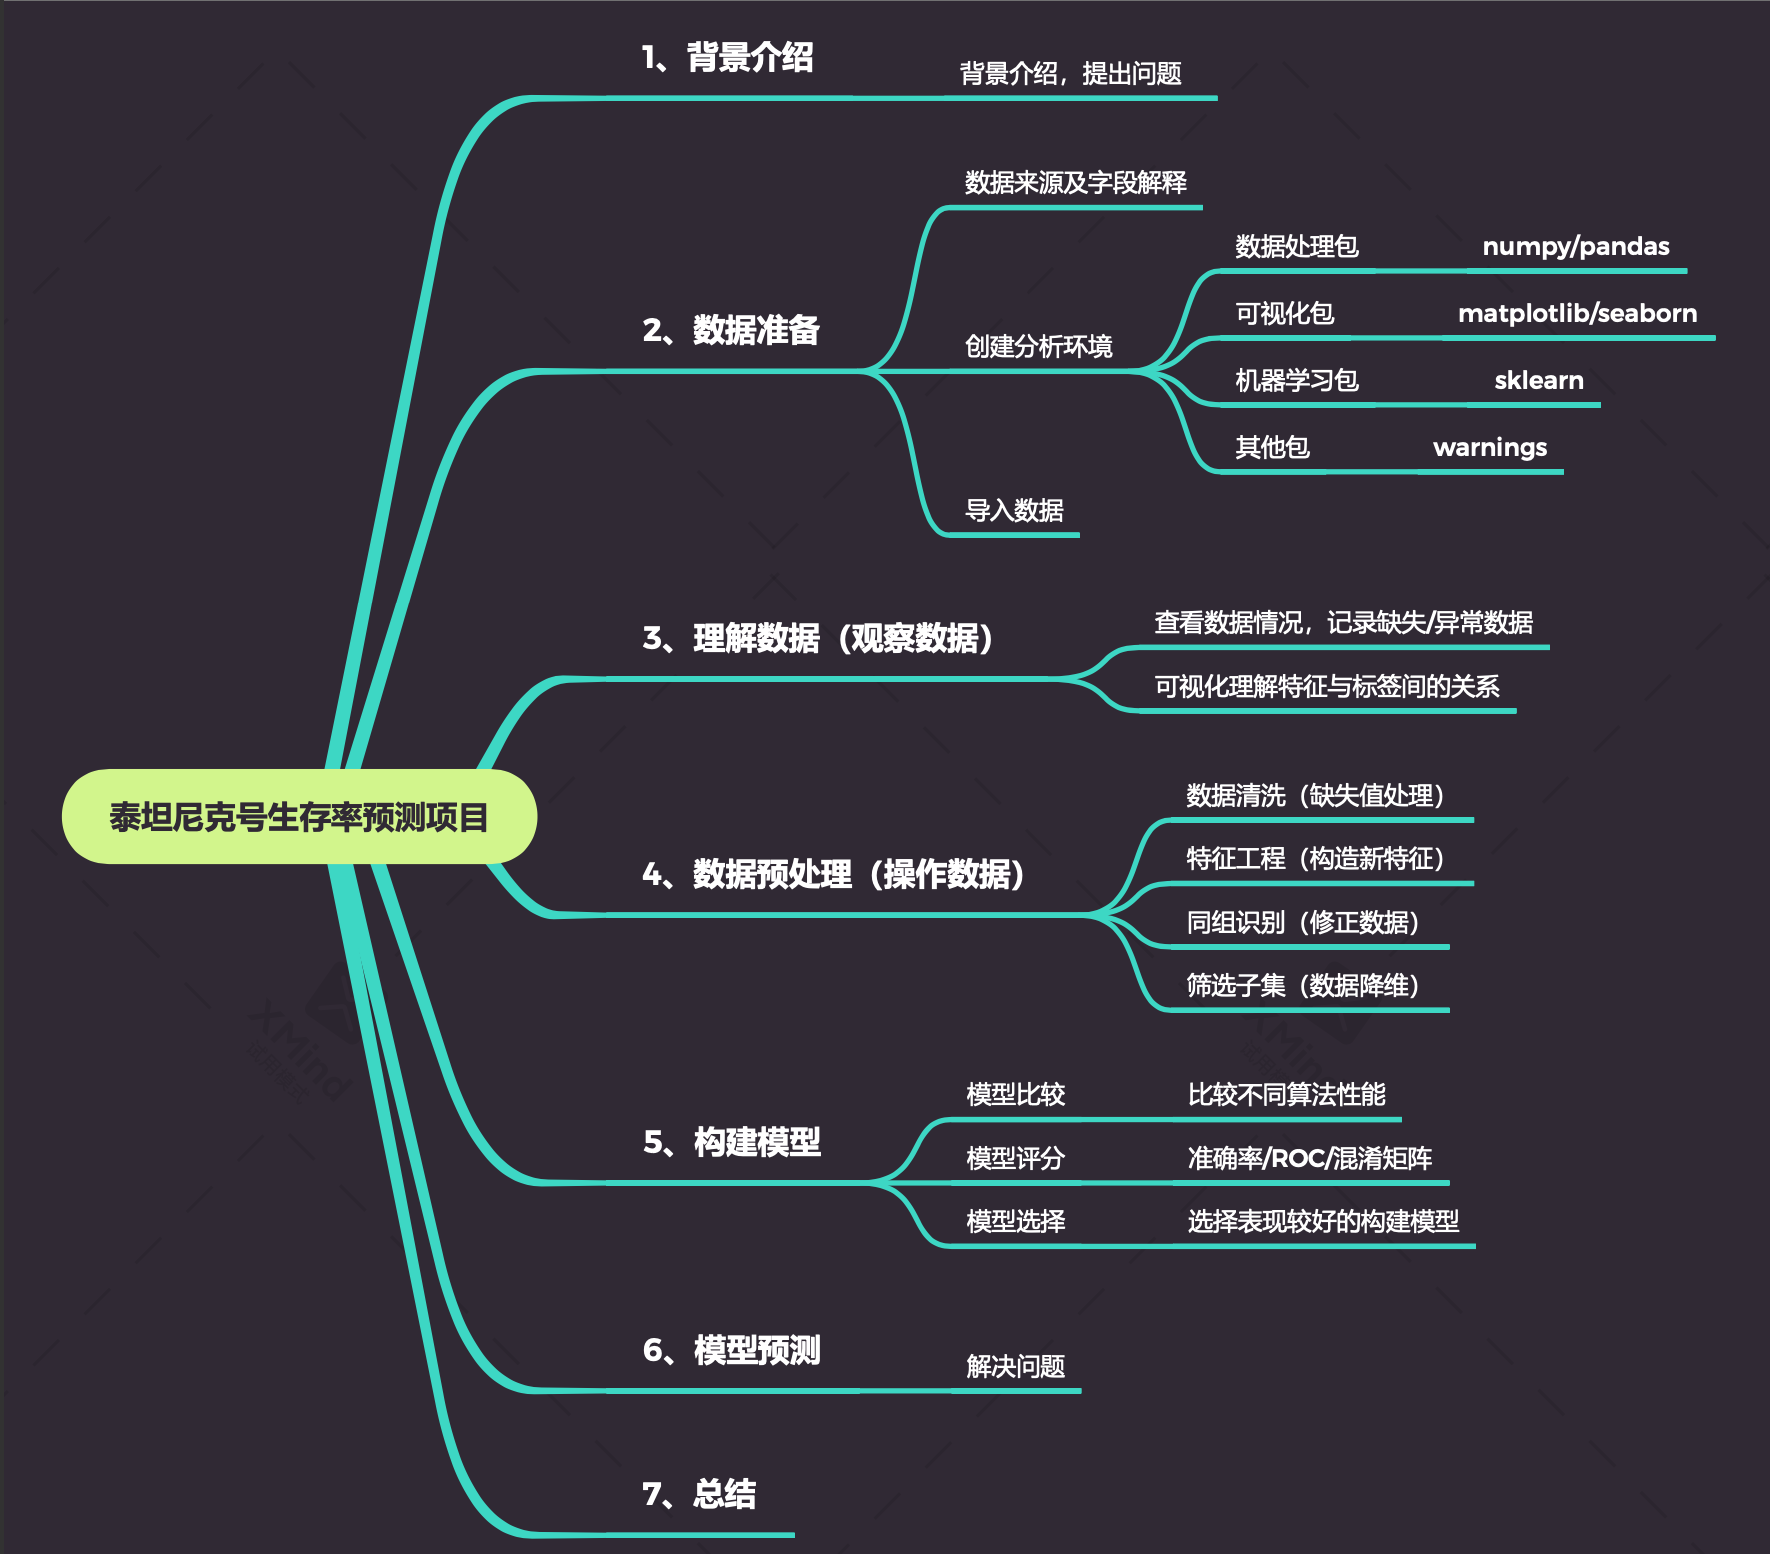

##  1.背景介绍

1912年4月15日，泰坦尼克号与冰山相撞后沉没。不幸的是，船上没有足够的救生艇供所有人使用，导致大量乘客和机组人员死亡。基于此，Kaggle平台提供了一个竞赛案例：Titanic:Machine Learning from Disaster。在该案例中，我们将探究什么样的人在此次海难中幸存的几率更高，并通过构建预测模型来预测乘客生存率。

本文通过数据可视化理解数据，并利用特征工程等方法挖掘更多有价值的特征，然后利用同组效应找出共性较强的群体并对其进行数据修正，在选择模型时分别比较了Gradient Boosting Classifier、Logistic Regression等多种方法，最终利用Gradient Boosting Classifier对乘客的生存率进行预测。

最终，在Kaggle上的得分为0.81339，排名约TOP3%。

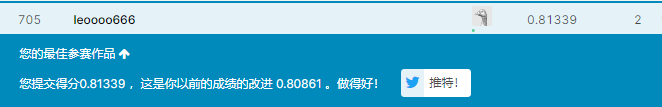

##  2.数据准备

本文数据集是来源于Kaggle平台中“Titanic: Machine Learning from Disaster”竞赛项目，数据字段释义如下：

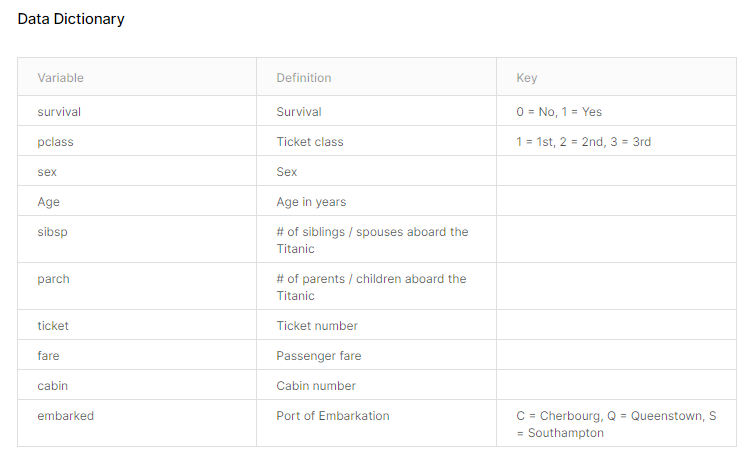

In [135]:
#(1)导入相关包
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#(2)设置sns样式
sns.set(style='white',context='notebook',palette='muted')
#(3)导入数据
train=pd.read_csv('E:\\Python\\Python项目\\Titanic\\train.csv')
test=pd.read_csv('E:\\Python\\Python项目\\Titanic\\test.csv')

## 3.理解数据

### 3.1查看数据情况

#### 3.1.1查看数据量和数据特征，理解数据含义

In [136]:
#分别查看实验数据集和预测数据集
print('实验数据大小',train.shape)
print('预测数据大小',test.shape)

实验数据大小 (891, 12)
预测数据大小 (418, 11)


该数据集共1309条数据，其中实验数据891条，预测数据418条。实验数据比预测数据多了一条，即字段“Survived”。

#### 3.1.2记录数据异常值、缺失值情况，方便进行下一步数据处理

In [137]:
#查看异常值
full=train.append(test,ignore_index=True)
full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


无明显异常值，几乎所有数值都在正常范围内。

In [138]:
#查看缺失值
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 97.2+ KB


结果表明，有4项缺失值，分别是Age/Fare/Cabin/Embarked,其中Cabin值缺失数量较多。

### 3.2查看特征与标签之间的关系

#### 3.2.1Embarked(登船地)与Survived:法国登船的乘客生存率最高

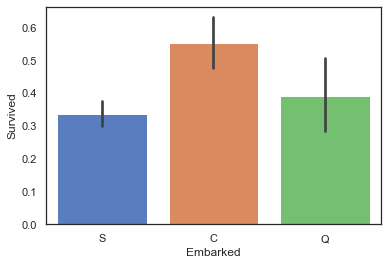

In [139]:
sns.barplot(data=train,x='Embarked',y='Survived')

In [140]:
#计算不同类型Embarked的乘客，其生存率是多少
print('Embarked为‘S’的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='S'].value_counts(normalize=True)[1])
print('Embarked为‘C’的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='C'].value_counts(normalize=True)[1])
print('Embarked为‘Q’的乘客，其生存率为%.2f'%full['Survived'][full['Embarked']=='Q'].value_counts(normalize=True)[1])

Embarked为‘S’的乘客，其生存率为0.34
Embarked为‘C’的乘客，其生存率为0.55
Embarked为‘Q’的乘客，其生存率为0.39


法国登船的乘客生存率最高，这可能与其头等舱乘客比例较高有关，因此继续查看不同登船地点各舱位乘客数量情况。

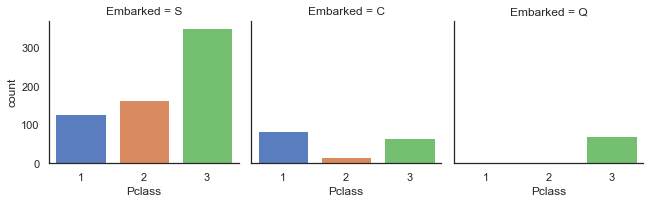

In [141]:
sns.factorplot('Pclass',col='Embarked',data=train,size=3,kind='count')

从图中可以看出，法国登船的乘客头等舱的比例更高。因此可以猜测，法国登船的乘客生存率最高，可能与头等舱的比例最高有关。

#### 3.2.2Parch(与乘客同行的父母及子女数量)与Survived：当与乘客同行的父母及子女数量适中时，生存率较高

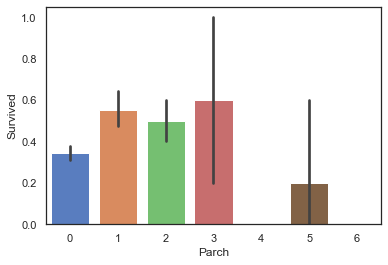

In [142]:
sns.barplot(data=train,x='Parch',y='Survived')

#### 3.2.3SibSp(与乘客同行的同辈数量)与Survived：当与乘客同行的同辈数量适中时生存率较高

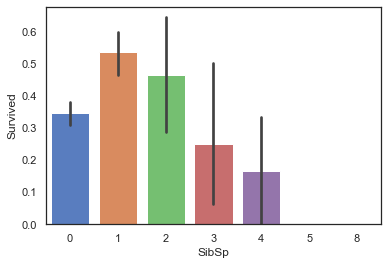

In [143]:
sns.barplot(data=train,x='SibSp',y='Survived')

#### 3.2.4Pclass(客舱等级)与Survived：客舱等级越高，生存率越高

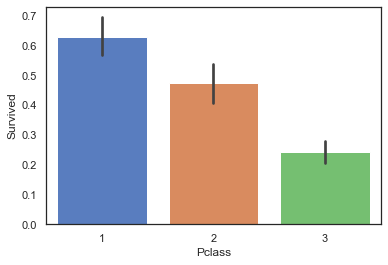

In [144]:
sns.barplot(data=train,x='Pclass',y='Survived')

#### 3.2.5Sex(性别)与Survived：女性的生存率远高于男性

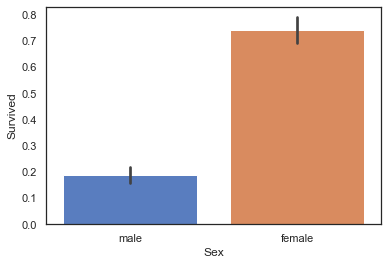

In [145]:
sns.barplot(data=train,x='Sex',y='Survived')

#### 3.2.6Age(年龄)与Survived:年龄在0-10岁之间的乘客生存率会更高

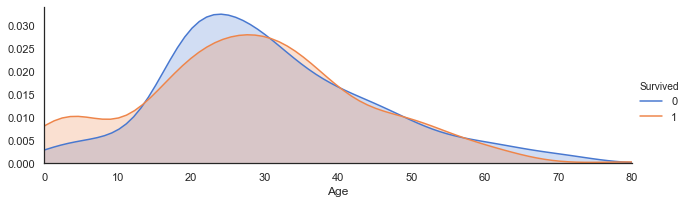

In [146]:
#创建坐标轴
ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Age',shade=True)
#其他信息：坐标轴范围，标签等
ageFacet.set(xlim=(0,train['Age'].max()))
ageFacet.add_legend()

#### 3.2.7Fare(票价)与Survived:票价低于30左右时生存率较低，票价越高生存率越高

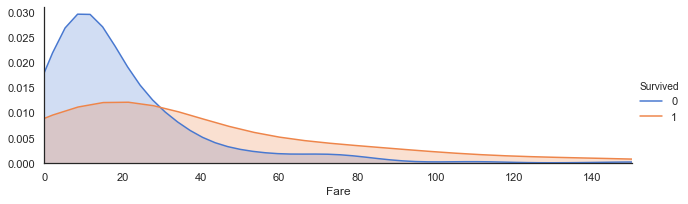

In [147]:
#创建坐标轴
ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Fare',shade=True)
#其他信息：坐标轴范围，标签等
ageFacet.set(xlim=(0,150))
ageFacet.add_legend()

## 4.数据预处理
数据预处理主要包括以下4个方面的内容：  
• 数据清洗（缺失值及异常值的处理）  
• 特征工程（基于对现有数据特征的理解构造新的特征，以挖掘数据的更多特点）  
• 同组识别（找出具有明显同组效应且违背整体规律的数据，对其数据进行修正）  
• 筛选子集（对数据进行降维，选择子集）

### 4.1数据清洗

对数据的缺失值、异常值进行处理，便于对数据进一步分析。本数据集中有4个字段的数据存在缺失情况，即Cabin/Embarked/Fare/Age，未发现数据存在明显异常情况。其中Age字段缺失值较多且为连续型数值，将在4.2特征工程章节挖取更多特征后进行缺失值填充。

#### 4.1.1Cabin（船舱号）缺失值填充

In [148]:
#对Cabin进行缺失值处理，利用U（Unknown）进行填充
full['Cabin']=full['Cabin'].fillna('U')
full['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

#### 4.1.2Embarked（登船地）缺失值填充

In [149]:
#对Embarked进行缺失值处理，查看缺失值情况
full[full['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [150]:
#查看Embarked数据分布情况
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [151]:
#查看Embarked数据分布情况可知在英国南安普顿登船的可能性最大，因此以此填充缺失值。
full['Embarked']=full['Embarked'].fillna('S')

#### 4.1.3Fare（票价）缺失值填充

In [152]:
#查看Fare缺失值情况
full[full['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,U,S


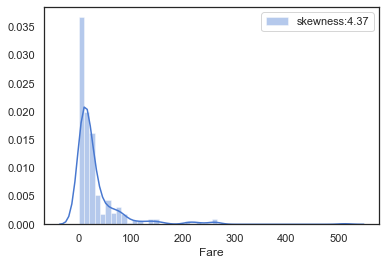

In [153]:
#查看票价的分布特征
farePlot=sns.distplot(full['Fare'][full['Fare'].notnull()],label='skewness:%.2f'%(full['Fare'].skew()))
farePlot.legend(loc='best')

In [154]:
#fare的分布呈左偏的趋势，偏度高达4.37，应对数据进行对数化处理，防止权重分布不均。
full['Fare']=full['Fare'].map(lambda x:np.log(x) if x>0 else 0)

In [155]:
#利用3等舱，登船港口为法国，舱位未知旅客的平均票价来填充缺失值。
full['Fare']=full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='C')&full['Cabin']=='U']['Fare'].mean())

对fare数据进行对数化处理的原因在于，取对数之后不会改变数据的性质和相关关系，但压缩了变量的尺度，数据更加平稳，也消弱了模型的共线性。

### 4.2特征工程

在理解原数据特征的基础上，特征工程通过对原有数据进行整合处理，得到新特征以反映数据的更多信息。

#### 4.2.1Name中的头衔信息-Title

旅客姓名中包含头衔信息，不同头衔也可以反映旅客的不同身份，而不同身份的旅客其生存率有可能会出现较大的差异。因此通过Name特征提取旅客头衔Title信息，并分析Title与Survived之间的关系。

In [156]:
#创造新特征Title
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
#查看Title数据分布
full['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Ms                2
Mlle              2
Mme               1
Dona              1
Lady              1
Capt              1
Don               1
Jonkheer          1
the Countess      1
Sir               1
Name: Title, dtype: int64

In [157]:
#将相近的Title信息整合在一起：
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'

full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

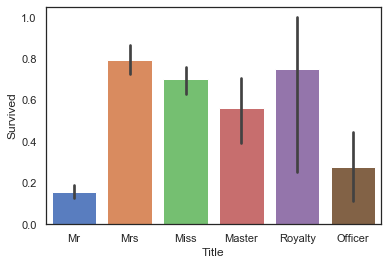

In [158]:
#观察新标签Title和Survived之间的关系
sns.barplot(data=full,x='Title',y='Survived')

头衔为‘Mr’及‘Officer’的乘客生存率明显偏低。

#### 4.2.2 familyNum及familySize信息

将Parch及SibSp字段整合得到一名乘客同行的家庭成员的总人数FamilyNum的字段，再根据家庭人员具体人数的多少得到家庭规模FamilySize这个新字段。

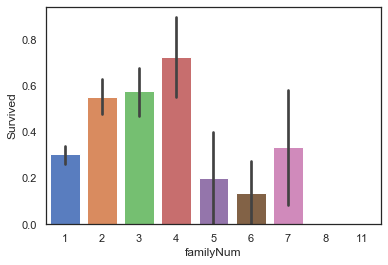

In [159]:
#familyNum
full['familyNum']=full['Parch']+full['SibSp']+1
#查看FamilyNum和Survived之间的关系
sns.barplot(data=full,x='familyNum',y='Survived')

家庭成员在2-4人时，生存率偏高，当没有家庭成员或家庭成员较多时，生存率偏低。

In [160]:
#familySize
#按照家庭成员人数的多少，将家庭规模分为三类:
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2
    
full['familySize']=full['familyNum'].map(familysize)
full['familySize'].value_counts()

0    790
1    437
2     82
Name: familySize, dtype: int64

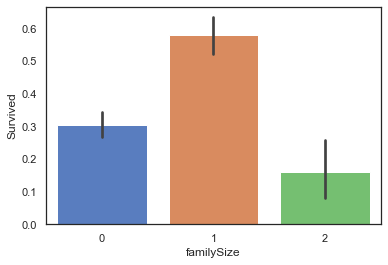

In [161]:
#查看familySize与Survived之间的关系
sns.barplot(data=full,x='familySize',y='Survived')

家庭规模适中时，乘客的生存率更高。

#### 4.2.3 Cabin客舱类型信息-Deck

Cabin字段的首字母代表客舱的类型，反映不同乘客群体的特点，也可能与乘客的生存率有关。

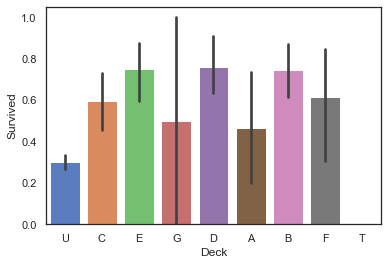

In [162]:
#截取Cabin字段首字母
full['Deck']=full['Cabin'].map(lambda x:x[0])
#查看不同Deck类型乘客的生存率
sns.barplot(data=full,x='Deck',y='Survived')

当客舱类型为B/D/E时，生存率较高；当客舱类型为U/T时，生存率较低。

#### 4.2.4共票号乘客数量TickCot及TickGroup

同一票号的乘客数量可能不同，可能也与生存率有关。

In [163]:
#TickCot
#提取各票号的乘客数量
TickCountDict={}
TickCountDict=full['Ticket'].value_counts()
TickCountDict.head()

CA. 2343        11
CA 2144          8
1601             8
S.O.C. 14879     7
3101295          7
Name: Ticket, dtype: int64

In [164]:
#将同票号乘客并入数据集中
full['TickCot']=full['Ticket'].map(TickCountDict)
full['TickCot'].head()

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64

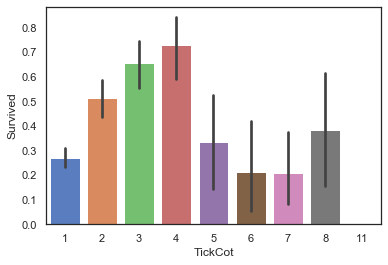

In [165]:
#查看TickCot与Survived之间的关系
sns.barplot(data=full,x='TickCot',y='Survived')

当相同票号乘客数量适中时，生存率较高。

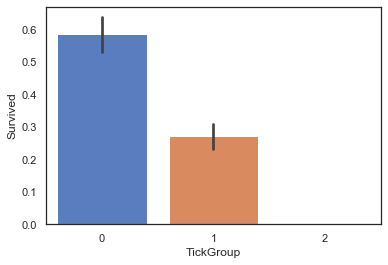

In [166]:
#TickGroup
#按照TickCot大小，将TickGroup分为3类：
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else:
        return 2
#得到各位乘客TickGroup的类别：
full['TickGroup']=full['TickCot'].map(TickCountGroup)
#查看TickGroup与Survived之间的关系：
sns.barplot(data=full,x='TickGroup',y='Survived')

#### 4.2.5Age缺失值填充-构建随机森林模型预测缺失的数据

查看Age与Parch、Pclass、Sex、SibSp、Title、familyNum、familySize、Deck、TickCot、TickGroup等变量的相关系数大小，筛选出相关性较高的变量构建预测模型

In [167]:
#查看缺失值情况
full[full['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,familyNum,familySize,Deck,TickCot,TickGroup
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,2.135148,U,Q,Mr,1,0,U,1,1
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,2.564949,U,S,Mr,1,0,U,1,1
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,1.977547,U,C,Mrs,1,0,U,1,1
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,1.977547,U,C,Mr,1,0,U,1,1
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,2.064226,U,Q,Miss,1,0,U,1,1


1、筛选数据

In [168]:
#筛选数据集
AgePre=full[['Age','Parch','Pclass','SibSp','Title','familyNum','TickCot']]
#进行one-hot编码
AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')
#查看变量间的相关性
AgeCorrDf=pd.DataFrame()
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()
#拼接数据
AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)
AgePre.head()

,Age,Parch,Pclass,SibSp,familyNum,TickCot,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


2、拆分数据并建立模型（利用随机森林构建模型）

In [169]:
#拆分实验集和预测集
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnknown=AgePre[AgePre['Age'].isnull()]
#生成实验数据的特征和标签
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_Y=AgeKnown['Age']
#生成预测数据的特征
AgeUnknown_X=AgeUnknown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

3、利用模型进行预测并填入原数据中

In [170]:
#模型得分
rfr.score(AgeKnown_X,AgeKnown_Y)
#预测年龄
AgeUnknown_Y=rfr.predict(AgeUnknown_X)
#填充预测数据
full.loc[full['Age'].isnull(),['Age']]=AgeUnknown_Y
full.info()
#此时已无缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  familyNum    1309 non-null   int64  
 14  familySize   1309 non-null   int64  
 15  Deck         1309 non-null   object 
 16  TickCot      1309 non-null   int64  
 17  TickGroup    1309 non-null   int64  
dtypes: float64(3), int64(8), object(7)
memory usage:

### 4.3同组识别

虽然通过分析数据已有特征与标签的关系可以构建有效的预测模型，但是部分具有明显共同特征的用户与整体模型逻辑并不一致。因此找出具有明显同组效应且违背整体规律的数据，对其数据进行修正，就可以有效提高模型的准确率。在Titanic案例中，主要探究相同姓氏的乘客是否存在明显的同组效应。  

提取两部分数据，分别查看其“姓氏”是否存在同组效应（因为性别和年龄与生存率之间的关系最为密切，因此用这两个特征作为分类条件）：  
1、12岁以上男性  
2、女性及年龄在12岁以下的儿童

In [171]:
#提取乘客的姓氏及相应的乘客数
full['Surname']=full['Name'].map(lambda x:x.split(',')[0].strip())
SurNameDict={}
SurNameDict=full['Surname'].value_counts()
full['SurnameNum']=full['Surname'].map(SurNameDict)

#将数据分为两组
MaleDf=full[(full['Sex']=='male')&(full['Age']>12)&(full['familyNum']>=2)]
FemChildDf=full[((full['Sex']=='female')|(full['Age']<=12))&(full['familyNum']>=2)]

#### 男性同组效应分析：

In [172]:
#分析男性同组效应
MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
MSurNamDf.value_counts()

0.0    89
1.0    19
0.5     3
Name: Survived, dtype: int64

大多数男性存在“同生共死”的特点，因此利用该同组效应，对生存率为1的男性数据进行修正，提高其被预测为“可以幸存”的概率。

In [173]:
#获得生存率为1的姓氏
MSurNamDict={}
MSurNamDict=MSurNamDf[MSurNamDf.values==1].index
MSurNamDict

Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname')

#### 女性及儿童同组效应分析 

In [174]:
#分析女性及儿童同组效应
FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
FCSurNamDf.value_counts()

1.000000    115
0.000000     27
0.750000      2
0.333333      1
0.142857      1
Name: Survived, dtype: int64

与男性同组特征相似，女性及儿童也存在明显的“同生共死”特点，因此利用该同组效应，对生存率为0的姓氏里的女性及儿童数据进行修正，提升其被预测为“并未幸存”的概率。

In [175]:
#获得生存率为0的姓氏
FCSurNamDict={}
FCSurNamDict=FCSurNamDf[FCSurNamDf.values==1].index
FCSurNamDict

Index(['Abbott', 'Abelson', 'Aks', 'Andersen-Jensen', 'Andrews', 'Angle',
       'Appleton', 'Astor', 'Backstrom', 'Baclini',
       ...
       'Thomas', 'Thorneycroft', 'Touma', 'Warren', 'Weisz', 'Wells', 'West',
       'Wick', 'Yasbeck', 'de Messemaeker'],
      dtype='object', name='Surname', length=115)

对数据集中这些姓氏的两组数据进行修正：  
男性数据修正为：1、性别改为女 2、年龄改为5；
女性及儿童数据修正为：1、性别改为男 2、年龄改为60。

In [176]:
#对数据集中的男性数据进行修正：1、性别改为女 2、年龄改为5
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Age']=5
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Sex']='female'
#对数据集中的女性及儿童数据进行修正：1、性别改为男 2、年龄改为60
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Age']=60
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Sex']='male'

### 4.4筛选子集

在对数据进行分析处理的过程中，数据的维度更高了，为提升数据有效性需要对数据进行降维处理。通过找出与乘客生存率‘Survived'相关性更高的特征，剔除重复的且相关性较低的特征，从而实现数据降维。

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

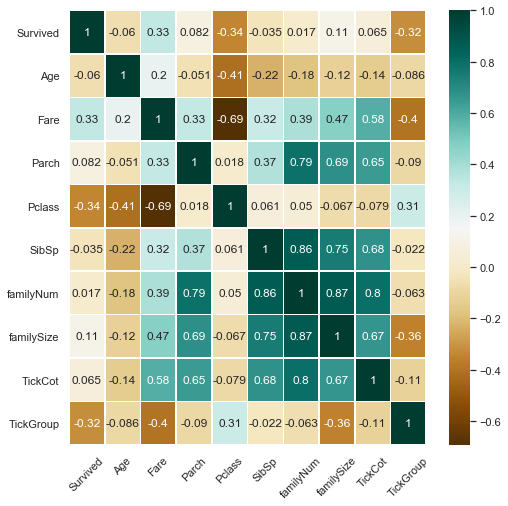

In [177]:
#人工筛选
fullSel=full.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)
#查看各特征与Survived的相关性
corrDf=pd.DataFrame()
corrDf=fullSel.corr()
corrDf['Survived'].sort_values(ascending=True)
#通过热力图，查看Survived与其他特征间相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass','Sex','SibSp','Title','familyNum','familySize','Deck','TickCot','TickGroup']].corr(),cmap='BrBG',annot=True,linewidths=.5)
plt.xticks(rotation=45)

先人工初步筛除与标签预测明显不相关或相关度很低的特征，再查看剩余特征与标签之间的相关性大小做进一步降维。

In [178]:
fullSel=fullSel.drop(['familyNum','SibSp','TickCot','Parch'],axis=1)
#进行one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full['Pclass'],prefix='Pclass')
TickGroupDf=pd.get_dummies(full['TickGroup'],prefix='TickGroup')
familySizeDf=pd.get_dummies(full['familySize'],prefix='familySize')
#拼接数据
fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,familySizeDf],axis=1)

## 5.构建模型

本文比较了多种机器学习算法的结果，并对表现较好的Gradient Boosting及Logistic Regression做进一步的对比，最终选择Gradient Boosting对乘客生存率进行预测。

### 5.1模型选择

#### 5.1.1建立模型

主要考虑使用以下几种常用的机器学习算法进行比较：  
•SVC 
•Decision Tree  
•Extra Trees  
•Gradient Boosting  
•Random Forest  
•KNN  
•Logistic Regression  
•Linear Discriminant Analysis  

In [179]:
#拆分实验数据和预测数据
experData=fullSel[fullSel['Survived'].notnull()]
preData=fullSel[fullSel['Survived'].isnull()]
#生成实验数据的特征和标签
experData_X=experData.drop('Survived',axis=1)
experData_Y=experData['Survived']
#生成预测数据的特征
preData_X=preData.drop('Survived',axis=1)


#导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.ensemble import VotingClassifier #模型组合

#设置kfold,交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

#### 5.1.2比较各种算法结果，进一步选择模型

In [ ]:
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_Y,scoring='accuracy',cv=kfold,n_jobs=-1))

#求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,  
                     'cv_std':cv_std,  
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})
cvResDf

#可视化查看各种算法的表现
sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

#### 5.1.3模型调优

综合以上模型表现，考虑选择GradientBoostingCla、LR两种模型进一步对比。

分别建立GradientBoostingClassifier以及LogisticRegression模型，并进行模型调优。

In [ ]:
#GradientBoostingClassifier模型
GBC=GradientBoostingClassifier()
gb_param_grid={'loss':["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}
modelgsGBC=GridSearchCV(GBC,param_grid=gb_param_grid,cv=kfold, 
                                     scoring="accuracy", n_jobs=-1, verbose=1)
modelgsGBC.fit(experData_X,experData_Y)
#LogisticRegression模型
modelLR=LogisticRegression()
LR_param_grid={'C':[1,2,3],
                'penalty':['l1','l2']}
modelgsLR=GridSearchCV(modelLR,param_grid=LR_param_grid,cv=kfold, 
                                     scoring="accuracy", n_jobs=-1, verbose=1)
modelgsLR.fit(experData_X,experData_Y)

### 5.2查看模型得分

1、查看模型准确度

In [ ]:
#modelgsGBC模型
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)
#modelgsLR模型
print('modelgsLR模型得分为：%.3f'%modelgsLR.best_score_)

GBC模型得分（即模型准确性）更高，继续比较其他指标的差异。

2、查看模型ROC曲线

In [ ]:
#Titanic GradientBoostingClassifier Model
#求出测试数据模型的预测值
modelgsGBCtestpre_y=modelgsGBC.predict(experData_X).astype(int)
#画图
from sklearn.metrics import roc_curve,auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold=roc_curve(experData_Y, modelgsGBCtestpre_y) ###计算真正率和假正率
roc_auc=auc(fpr,tpr) ###计算auc的值

plt.figure()
lw=2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic GradientBoostingClassifier Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Titanic LogisticRegression Model
#求出测试数据模型的预测值
modelgsLRtestpre_y=modelgsLR.predict(experData_X).astype(int)
#画图
from sklearn.metrics import roc_curve,auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold=roc_curve(experData_Y, modelgsLRtestpre_y) ###计算真正率和假正率
roc_auc=auc(fpr,tpr) ###计算auc的值

plt.figure()
lw=2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic LogisticRegression Model')
plt.legend(loc="lower right")
plt.show()

GradientBoostingClassifier和LogisticRegression的AUC分别为0.852和0.820，即GradientBoostingClassifier模型效果更好。

3、查看混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
print('GradientBoostingClassifier模型混淆矩阵为\n',confusion_matrix(experData_Y.astype(int).astype(str),modelgsGBCtestpre_y.astype(str)))
print('LinearRegression模型混淆矩阵为\n',confusion_matrix(experData_Y.astype(int).astype(str),modelgsLRtestpre_y.astype(str)))

通过混淆矩阵可以看出，GBC模型找出正例的能力高于LR模型。综合考虑，本项目中利用GBC方法进行模型预测。

## 6.模型预测

In [ ]:
#TitanicGBCmodle
GBCpreData_y=modelgsGBC.predict(preData_X)
GBCpreData_y=GBCpreData_y.astype(int)
#导出预测结果
GBCpreResultDf=pd.DataFrame()
GBCpreResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived']=GBCpreData_y
GBCpreResultDf
#将预测结果导出为csv文件
GBCpreResultDf.to_csv('E:/Python/Python项目/Titanic/TitanicGBCmodle.csv',index=False)

## 7.总结

将结果上传至Kaggle中，最终预测得分为0.81339，排名约TOP3%。

在本次Kaggle项目过程中，参考学习了很多其他竞赛方案的分析思路及数据处理技巧，如：考虑同组效应，数据对数化处理，多种模型比较结果优劣等等。在项目过程中，主要从以下三个方面进行改进来提升结果准确性：

1、模型优选：分别选取多种模型进行建模，根据模型评分进行初步比较，最终综合考虑多个性能指标来选择合适的预测模型；
2、特征挖掘与筛选：通过挖掘新的特征并筛选相关性较高的特征，来选择最终训练模型的特征集合；  
3、数据整容：缺失值的填充以及“不合群”数据的处理也直接影响模型的最终预测结果。